In [1]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
model = 'gnoc' # 'gnoc', 'scn', 'escn'
enhancement = 'gap' # 'vanilla', 'da', 'gap', 'da-gap'
mapping = {'vanilla': 'baseline',
           'da': 'ca',
           'gap': 'gap',
           'da-gap': 'ca+gap'}

In [49]:
path = "/home/jovyan/shared-scratch/jhoon/ocp2023/results/attentions/indv/"
files = os.listdir(path)

# derive file that contains model and enahncement from files list
target_file_list = [file for file in files if '-'+model+'-' in file and '-'+enhancement+'-' in file] #[0]
if enhancement == 'gap':
    # remove file containing 'da-gap' from the list
    target_file_list = [file for file in target_file_list if 'da-gap' not in file]

assert len(target_file_list) == 1, "More than one file found"
target_file = target_file_list[0]
target_file

'attn-rebase-gap-catberta_1221_2208-eval-gnoc-strc.pkl'

In [50]:
target_file_list

['attn-rebase-gap-catberta_1221_2208-eval-gnoc-strc.pkl']

In [51]:
attn = pd.read_pickle(path+target_file)['weights']
attn

tensor([[0.1332, 0.2493, 0.2084, 0.2251, 0.1516, 0.1112, 0.1236, 0.2192, 0.0372,
         0.1348, 0.1213, 0.0830],
        [0.2387, 0.2729, 0.3579, 0.2806, 0.3657, 0.2410, 0.3672, 0.3311, 0.3217,
         0.3486, 0.2065, 0.2110],
        [0.6130, 0.4604, 0.4270, 0.4796, 0.4795, 0.6246, 0.5049, 0.4467, 0.6381,
         0.5112, 0.6566, 0.6915],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000]])

In [52]:
attn.shape

torch.Size([4, 12])

In [53]:
# convert this to a dataframe where each column represents the section and each row represents the attention head
# the number of head is 12, the number of section is 4

df_attn = pd.DataFrame(attn).T

# Remove column named 3
df_attn.drop(columns=3, inplace=True)

# Change the remaining column names
df_attn.columns = ['Ads.', 'Cat.', 'Conf.']

# Calculate values for new '<s>' column
df_attn.insert(0, '<s>', 1 - (df_attn['Ads.'] + df_attn['Cat.'] + df_attn['Conf.']))

# add column-wise average row as 13th row
df_attn.loc['avg'] = df_attn.mean(axis=0)
df_attn

,<s>,Ads.,Cat.,Conf.
0,0.015123,0.133176,0.238727,0.612975
1,0.017355,0.249343,0.272909,0.460393
2,0.006707,0.208375,0.357917,0.427001
3,0.014659,0.225147,0.280573,0.479621
4,0.003145,0.151640,0.365695,0.479521
5,0.023327,0.111151,0.240967,0.624556
6,0.004331,0.123646,0.367165,0.504859
7,0.002938,0.219228,0.331138,0.446697
8,0.003037,0.037200,0.321682,0.638081
9,0.005335,0.134798,0.348634,0.511233


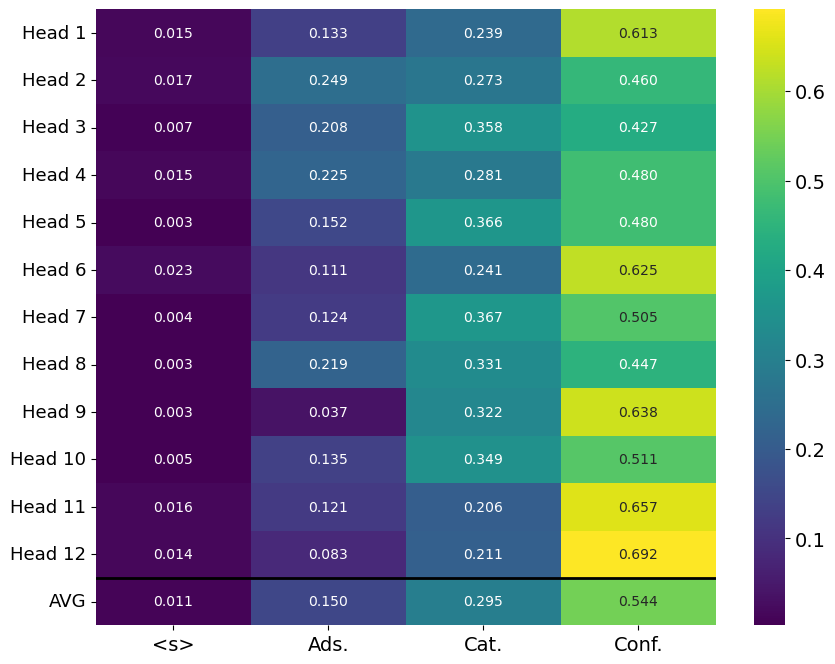

In [54]:
# Replace the ytick labels
ytick_labels = [f"Head {i+1}" for i in range(12)] + ["AVG"]

# Plotting heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(df_attn, annot=True, fmt=".3f", 
                      cmap='viridis', cbar=True, cbar_kws={'orientation': 'vertical'})

# Enlarge the font of x, y ticks and ticks in the color bar
plt.xticks(fontsize=14)
plt.yticks(ticks=np.arange(len(df_attn)) + 0.5, labels=ytick_labels, rotation=0, fontsize=13)

# Adjust color bar tick label size
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

# Place a line between Head 12 and AVG
plt.axhline(y=12, color='black', linewidth=2)

plt.savefig(f"attention/{model}_{mapping[enhancement]}.png", dpi=300, bbox_inches='tight')